# ***PERBANDINGAN LABELLING MENGGUNAKAN GEMINI 2.5 DENGAN LEXICON INSET KASUS SENTIMENT MASYARAKAT TERHADAP CALON PELATIH BARU TIMNAS INDONESIA JOHN HERDMAN***

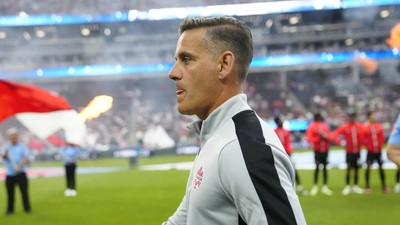

In [1]:
!pip install demoji
!pip install evaluate
!pip install --upgrade transformers
import torch
print("GPU Aktif:" if torch.cuda.is_available() else "GPU TIDAK AKTIF (Hanya CPU)")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.3 MB/s eta 0:00:00
GPU Aktif:


In [2]:
import warnings
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import demoji
import torch
import torch.nn as nn
import evaluate

from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)

warnings.filterwarnings('ignore')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv('/content/drive/MyDrive/ROAD TO GEMASTIK XIX/Analisis Sentiment/John Herdman/dataset_labelled_gem.csv')
df.head(15)

,text,published,source,sentiment
0,BUWANG2 UWANG MUBÀDIR😢,2025-12-20T08:23:48Z,Youtube,Negative
1,DIPASTIKAN TRIBUN SEPI...!!!,2025-12-20T10:58:58Z,Youtube,Negative
2,Hoaks,2025-12-20T08:28:44Z,Youtube,Neutral
3,"Halla kaga guna, kalau liga indo kaga di perbaiki",2025-12-20T07:02:38Z,Youtube,Negative
4,hoax,2025-12-20T10:35:03Z,Youtube,Neutral
5,STY must come back!,2025-12-20T08:54:28Z,Youtube,Negative
6,"Jangan pusing2, Erik n Towel aja suruh ngelati...",2025-12-20T16:13:45Z,Youtube,Negative
7,Harusnya dilatih coach justin,2025-12-20T07:45:58Z,Youtube,Negative
8,Welcome mr Hermanto 😊,2025-12-21T00:30:34Z,Youtube,Positive
9,Semoga hasilnya memuaskan amin ya rabbal'alamin,2025-12-21T04:15:22Z,Youtube,Positive


In [6]:
df['sentiment'].value_counts()

,count
sentiment,
Neutral,2946
Negative,1752
Positive,1067


# **PREPROCESSING TEXT**

### **CASE FOLDING**

In [7]:
df['text_cf'] = df['text'].str.lower()
df.head()

,text,published,source,sentiment,text_cf
0,BUWANG2 UWANG MUBÀDIR😢,2025-12-20T08:23:48Z,Youtube,Negative,buwang2 uwang mubàdir😢
1,DIPASTIKAN TRIBUN SEPI...!!!,2025-12-20T10:58:58Z,Youtube,Negative,dipastikan tribun sepi...!!!
2,Hoaks,2025-12-20T08:28:44Z,Youtube,Neutral,hoaks
3,"Halla kaga guna, kalau liga indo kaga di perbaiki",2025-12-20T07:02:38Z,Youtube,Negative,"halla kaga guna, kalau liga indo kaga di perbaiki"
4,hoax,2025-12-20T10:35:03Z,Youtube,Neutral,hoax


### **Emoji Handling**

In [8]:
def convert_emojis(text):
  return demoji.replace(text, "")

df['text_eh'] = df['text_cf'].fillna('').astype(str)
df['text_eh'] = df['text_eh'].apply(convert_emojis)

df.head()

,text,published,source,sentiment,text_cf,text_eh
0,BUWANG2 UWANG MUBÀDIR😢,2025-12-20T08:23:48Z,Youtube,Negative,buwang2 uwang mubàdir😢,buwang2 uwang mubàdir
1,DIPASTIKAN TRIBUN SEPI...!!!,2025-12-20T10:58:58Z,Youtube,Negative,dipastikan tribun sepi...!!!,dipastikan tribun sepi...!!!
2,Hoaks,2025-12-20T08:28:44Z,Youtube,Neutral,hoaks,hoaks
3,"Halla kaga guna, kalau liga indo kaga di perbaiki",2025-12-20T07:02:38Z,Youtube,Negative,"halla kaga guna, kalau liga indo kaga di perbaiki","halla kaga guna, kalau liga indo kaga di perbaiki"
4,hoax,2025-12-20T10:35:03Z,Youtube,Neutral,hoax,hoax


### **Cleaning (Noise Removal)**

In [9]:
df['text_clean'] = df['text_eh'].str.replace(r"@\w+|#\w+|https?:\/\/\S+|www\.\S+|[^A-Za-z0-9\s]", " ", regex=True)
df['text_clean'] = df['text_clean'].str.replace(r"\s+", " ", regex=True).str.strip()
df.head()

,text,published,source,sentiment,text_cf,text_eh,text_clean
0,BUWANG2 UWANG MUBÀDIR😢,2025-12-20T08:23:48Z,Youtube,Negative,buwang2 uwang mubàdir😢,buwang2 uwang mubàdir,buwang2 uwang mub dir
1,DIPASTIKAN TRIBUN SEPI...!!!,2025-12-20T10:58:58Z,Youtube,Negative,dipastikan tribun sepi...!!!,dipastikan tribun sepi...!!!,dipastikan tribun sepi
2,Hoaks,2025-12-20T08:28:44Z,Youtube,Neutral,hoaks,hoaks,hoaks
3,"Halla kaga guna, kalau liga indo kaga di perbaiki",2025-12-20T07:02:38Z,Youtube,Negative,"halla kaga guna, kalau liga indo kaga di perbaiki","halla kaga guna, kalau liga indo kaga di perbaiki",halla kaga guna kalau liga indo kaga di perbaiki
4,hoax,2025-12-20T10:35:03Z,Youtube,Neutral,hoax,hoax,hoax


### **Normalisasi Slang**

In [10]:
df_norm = pd.read_csv('/content/drive/MyDrive/ROAD TO GEMASTIK XIX/Analisis Sentiment/John Herdman/kamus_alay.csv')
slang_dict = dict(zip(df_norm['slang'], df_norm['formal']))

def hapus_katapanjang(text):
  return re.sub(r'(.)\1{2, }', r'\1', text)

def normalize_slang(text):
  text = hapus_katapanjang(text)
  words = text.split()
  normalized_words = [slang_dict.get(word, word) for word in words]
  return ' '.join(normalized_words)

df['text_norm'] = df['text_clean'].apply(normalize_slang)
df.head()

,text,published,source,sentiment,text_cf,text_eh,text_clean,text_norm
0,BUWANG2 UWANG MUBÀDIR😢,2025-12-20T08:23:48Z,Youtube,Negative,buwang2 uwang mubàdir😢,buwang2 uwang mubàdir,buwang2 uwang mub dir,buwang2 uwang mub dir
1,DIPASTIKAN TRIBUN SEPI...!!!,2025-12-20T10:58:58Z,Youtube,Negative,dipastikan tribun sepi...!!!,dipastikan tribun sepi...!!!,dipastikan tribun sepi,dipastikan tribun sepi
2,Hoaks,2025-12-20T08:28:44Z,Youtube,Neutral,hoaks,hoaks,hoaks,hoaks
3,"Halla kaga guna, kalau liga indo kaga di perbaiki",2025-12-20T07:02:38Z,Youtube,Negative,"halla kaga guna, kalau liga indo kaga di perbaiki","halla kaga guna, kalau liga indo kaga di perbaiki",halla kaga guna kalau liga indo kaga di perbaiki,halla kagak guna kalau liga indonesia kagak di...
4,hoax,2025-12-20T10:35:03Z,Youtube,Neutral,hoax,hoax,hoax,hoax


# **Labelling Lexicon InSet**

In [11]:
def load_inset_lexicon(pos_path, neg_path):
  lexicon = {}

  df_pos = pd.read_csv(pos_path, sep='\t')
  for _, row in df_pos.iterrows():
    lexicon[row['word']] = int(row['weight'])

  df_neg = pd.read_csv(neg_path, sep='\t')
  for _, row in df_neg.iterrows():
    lexicon[row['word']] = int(row['weight'])

  return lexicon

def get_sentiment(text, lexicon):
  words = text.split()
  score = 0

  for word in words:
    score += lexicon.get(word, 0)

  if score > 0:
    return 'Positive'
  elif score < 0:
    return 'Negative'
  else:
    return 'Neutral'

pos_path ='/content/drive/MyDrive/ROAD TO GEMASTIK XIX/Analisis Sentiment/John Herdman/LexiconInset/positive.tsv'
neg_path = '/content/drive/MyDrive/ROAD TO GEMASTIK XIX/Analisis Sentiment/John Herdman/LexiconInset/negative.tsv'

lexicon_dict = load_inset_lexicon(pos_path, neg_path)

df['sentiment_inset'] = df['text_norm'].apply(lambda x: get_sentiment(x, lexicon_dict))
df[['text', 'sentiment_inset']]

,text,sentiment_inset
0,BUWANG2 UWANG MUBÀDIR😢,Neutral
1,DIPASTIKAN TRIBUN SEPI...!!!,Negative
2,Hoaks,Neutral
3,"Halla kaga guna, kalau liga indo kaga di perbaiki",Negative
4,hoax,Negative
...,...,...
5760,kgk akn merubah parfum timnas.mlh tambah mloso...,Negative
5761,nah gini cari pelatih yang paham tak tik bisa ...,Negative
5762,afaa iyaaðŸ—¿,Neutral
5763,"pssi: jgn seriusss,, lu bagus lu pecat [sticker]",Negative


### ***REMOVE STOPWORDS***

In [12]:
def load_stopwords(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            words = f.read().splitlines()
        return set(words)
    except FileNotFoundError:
        print(f"File {file_path} tidak ditemukan!")
        return set()

path_to_file = '/content/drive/MyDrive/ROAD TO GEMASTIK XIX/Analisis Sentiment/John Herdman/id.stopwords.txt'
base_stopwords = load_stopwords(path_to_file)

custom_additions = [
    'yg', 'ga', 'gak', 'kalo', 'kl', 'klo', 'dr', 'sdh', 'udh', 'dah',
    'sih', 'kok', 'kek', 'bgt', 'banget', 'ni', 'tu', 'aja', 'doang',
    'nya', 'tuh', 'dong', 'kan', 'lah', 'mah', 'si', 'sama', 'buat',
    'emang', 'mang', 'y', 'ya', 'yah', 'wkwk', 'wkwkwk'
]

final_stopwords = base_stopwords.union(custom_additions)

final_stopwords_list = list(final_stopwords)

print(f"Total Stopwords Loaded: {len(final_stopwords_list)} kata")



Total Stopwords Loaded: 786 kata


In [13]:
stopwords_set = set(final_stopwords_list)

def remove_stopwords(text):
    # Pecah kalimat, filter kata yang tidak ada di set stopwords, gabung lagi
    return ' '.join([word for word in str(text).split() if word.lower() not in stopwords_set])

# Buat kolom baru
df['text_no_stopwords'] = df['text_norm'].apply(remove_stopwords)

# Cek hasil
print(df[['text_norm', 'text_no_stopwords']].head())

                                           text_norm  \
0                              buwang2 uwang mub dir   
1                             dipastikan tribun sepi   
2                                              hoaks   
3  halla kagak guna kalau liga indonesia kagak di...   
4                                               hoax   

                           text_no_stopwords  
0                      buwang2 uwang mub dir  
1                                tribun sepi  
2                                      hoaks  
3  halla kagak liga indonesia kagak perbaiki  
4                                       hoax  


# **Exploratory Data Analysis**

Agreement Score: 39.51%


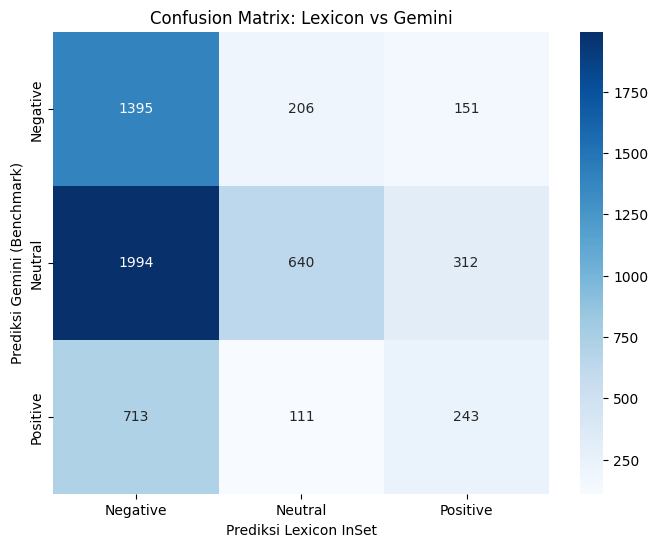

In [14]:
# Anggap Gemini adalah "Kunci Jawaban Sementara" (Benchmark)
y_true = df['sentiment']
y_pred = df['sentiment_inset']

# Hitung Agreement Score (Seberapa sepakat mereka)
agreement = accuracy_score(y_true, y_pred)
print(f"Agreement Score: {agreement:.2%}")

# Visualisasi Heatmap
labels = ['Negative', 'Neutral', 'Positive']
cm = confusion_matrix(y_true, y_pred, labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Prediksi Lexicon InSet')
plt.ylabel('Prediksi Gemini (Benchmark)')
plt.title('Confusion Matrix: Lexicon vs Gemini')
plt.show()

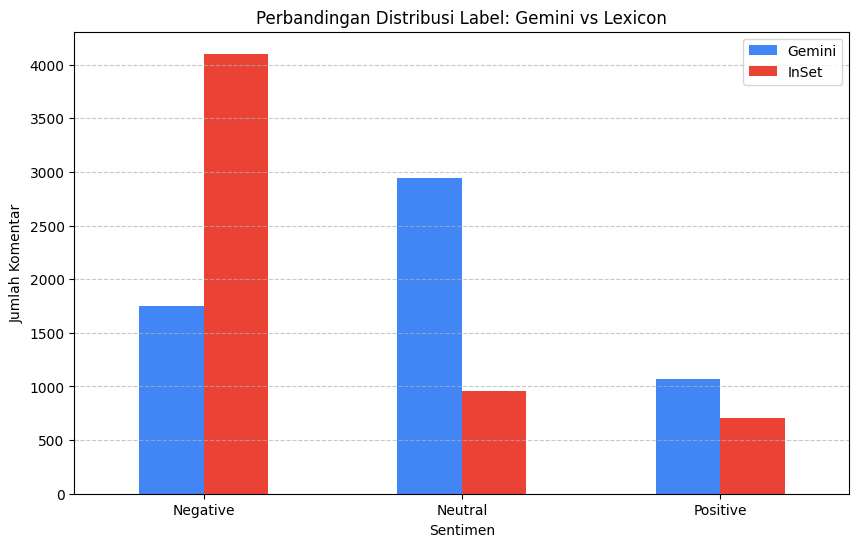

In [15]:
# Hitung jumlah per label
counts_gemini = df['sentiment'].value_counts()
counts_inset = df['sentiment_inset'].value_counts()

# Bikin DataFrame ringkasan
df_compare = pd.DataFrame({'Gemini': counts_gemini, 'InSet': counts_inset}).fillna(0)

# Plot
df_compare.plot(kind='bar', figsize=(10, 6), color=['#4285F4', '#EA4335']) # Warna Google Blue & Red
plt.title('Perbandingan Distribusi Label: Gemini vs Lexicon')
plt.ylabel('Jumlah Komentar')
plt.xlabel('Sentimen')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### ***WORD CLOUD***

In [16]:
def make_cloud(text_data, title, color_theme):
    if len(text_data) == 0: return # Skip jika data kosong

    wc = WordCloud(width=800, height=400, background_color='white', colormap=color_theme).generate(' '.join(text_data.astype(str)))
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=14)
    plt.show()

### ***FREKUENSI KATA***

In [17]:
def plot_top_words(text_data, title, color_palette, top_n=10):
    if len(text_data) == 0: return

    # Hitung Frekuensi
    vec = CountVectorizer().fit(text_data.astype(str))
    bag_of_words = vec.transform(text_data.astype(str))
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:top_n]

    # Buat Dataframe & Plot
    df_freq = pd.DataFrame(words_freq, columns=['Kata', 'Frekuensi'])

    plt.figure(figsize=(8, 5))
    sns.barplot(x='Frekuensi', y='Kata', data=df_freq, palette=color_palette)
    plt.title(title, fontsize=14)
    plt.xlabel("Jumlah Kemunculan")
    plt.show()

### **LABELLING GEMINI 2.5**

In [18]:
def visualize_gemini(df):
    print("WORDCLOUD SENTIMEN: GEMINI (LLM)")

    # 1. Negative (Merah)
    data_neg = df[df['sentiment'] == 'Negative']['text_no_stopwords']
    make_cloud(data_neg, "Gemini: Negative Words", "Reds")

    # 2. Neutral (Biru)
    data_neu = df[df['sentiment'] == 'Neutral']['text_no_stopwords']
    make_cloud(data_neu, "Gemini: Neutral Words", "Blues")

    # 3. Positive (Hijau)
    data_pos = df[df['sentiment'] == 'Positive']['text_no_stopwords']
    make_cloud(data_pos, "Gemini: Positive Words", "Greens")

WORDCLOUD SENTIMEN: GEMINI (LLM)


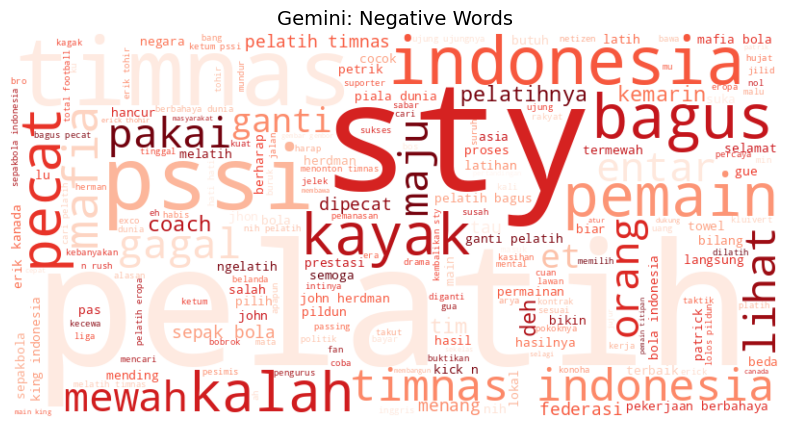

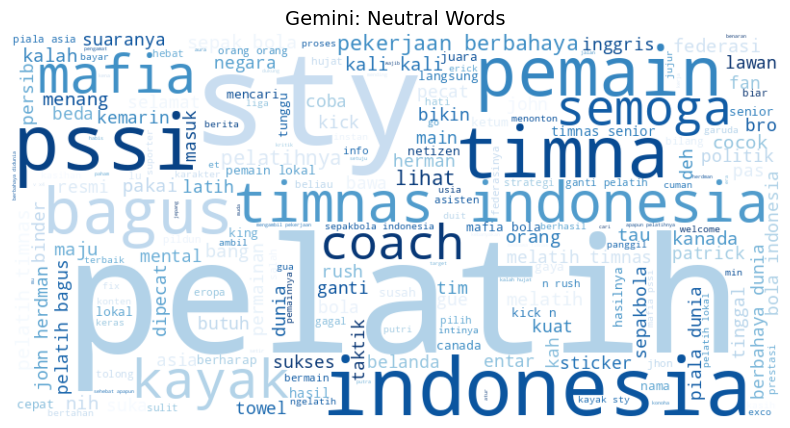

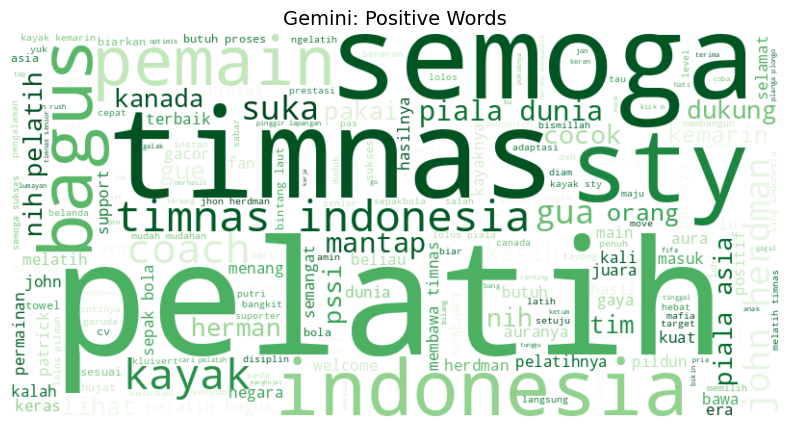

In [19]:
visualize_gemini(df)

In [20]:
def freq_gemini(df):
    print("TOP 10 KATA: GEMINI (LLM)")

    # Negative (Merah)
    neg = df[df['sentiment'] == 'Negative']['text_no_stopwords']
    plot_top_words(neg, "Top Kata Negative (Gemini)", "Reds_r")

    # Neutral (Biru)
    neu = df[df['sentiment'] == 'Neutral']['text_no_stopwords']
    plot_top_words(neu, "Top Kata Neutral (Gemini)", "Blues_r")

    # Positive (Hijau)
    pos = df[df['sentiment'] == 'Positive']['text_no_stopwords']
    plot_top_words(pos, "Top Kata Positive (Gemini)", "Greens_r")

TOP 10 KATA: GEMINI (LLM)


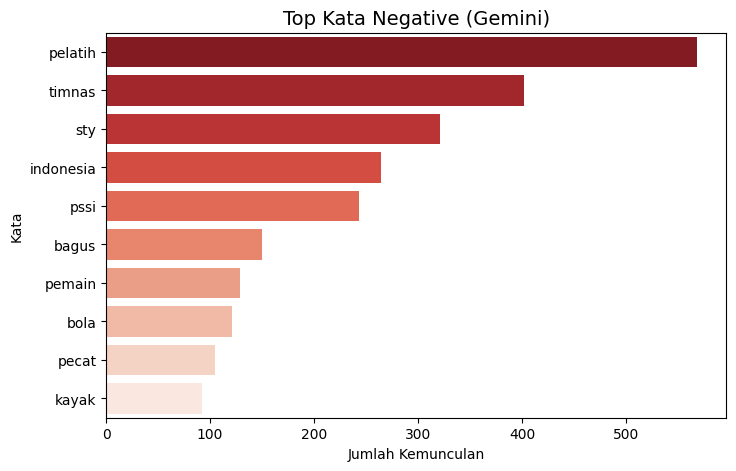

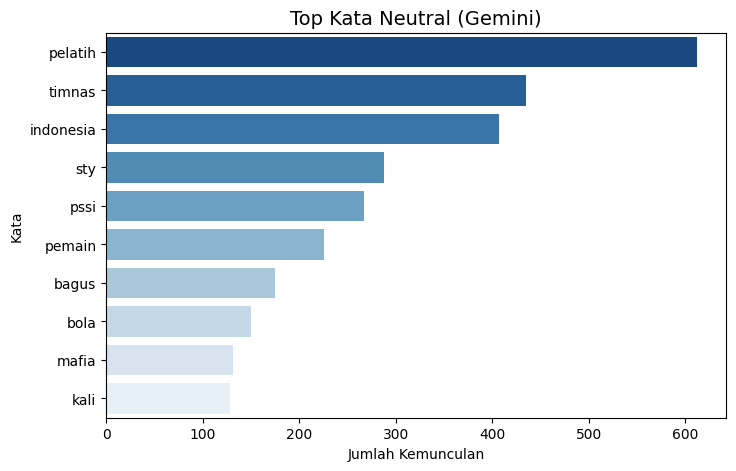

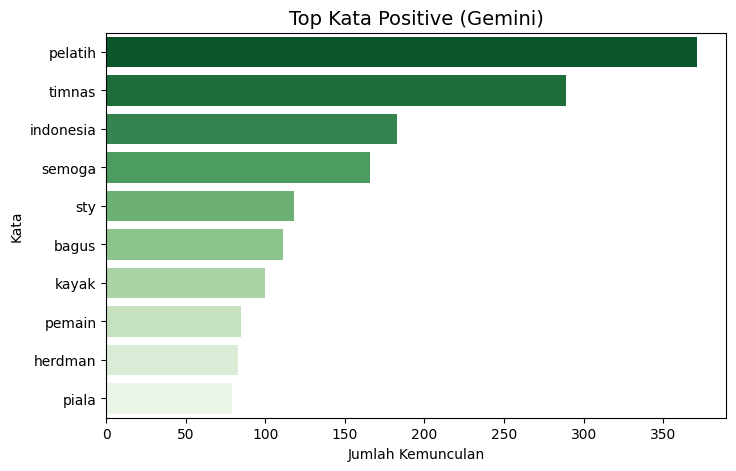

In [21]:
freq_gemini(df)

In [22]:
sarcasm_suspects = df[
    (df['sentiment'] == 'Negative') &
    (df['text'].str.contains('bagus', case=False, na=False))
]

proof_table = sarcasm_suspects[['text', 'sentiment', 'sentiment_inset']]


print(f"Ditemukan {len(proof_table)} komentar 'Negative' yang mengandung kata 'bagus'.")
print("--- BUKTI DETEKSI SARKASME ---")

pd.set_option('display.max_colwidth', None)
proof_table.head(10)

Ditemukan 142 komentar 'Negative' yang mengandung kata 'bagus'.
--- BUKTI DETEKSI SARKASME ---


,text,sentiment,sentiment_inset
6,"Jangan pusing2, Erik n Towel aja suruh ngelatih....biar tambah bagus timnasnya .....",Negative,Negative
25,"Sebagus apapun percuma😂bakal jd cemilan netizen, pundit dan mafia2 😂😂",Negative,Negative
77,"Kl pake diaspora semua mungkin bakal bagus kl sdh pake titipan polisi dan TNI,lokal prett akan hancur kembali.",Negative,Negative
88,Bagus si bagus nnty saat2 berkembng & pelan2 naik level eh tiba2 tngh jln d cut bgtu saja . Kn aneh 🤦‍♂️🤦‍♂️🤦‍♂️,Negative,Negative
114,"Bagusan sty dr berbagai pertimbangan... Slma erik tohir yg pimpin pssi, mimpi sj kita bs ke pildun",Negative,Negative
132,"palingan ujung nya ada pemain titipan , wajib lokal preet, lokal kalau bagus sih gpp lah ini lokal yg gak bsa passing msh aja di masukin squad",Negative,Negative
305,Raportnya tidak lebih bagus dari sty,Negative,Negative
336,pelatih Jhon herdman dari inggris di bandinkan sm si tayong \n kualitas pelatih jauh masing lebih bagus si tayong.,Negative,Positive
393,"Bayangin aja dulu Herdman nanti hasilnya bagus eh tiba tiba di pecat sama Federasi.\n Ya begitulah hari hari yg di lalui Fans Timnas Indonesia Jaman Kegelapan, pas udah kelihatan hasilnya bagus eh tiba tiba di pecat.\n \n Jadi ya gak berharap banyak",Negative,Negative
602,Gedabrus... Buktinya STY yang sudah terbukti bagus,Negative,Negative


### **Labelling Lexicon InSet**

In [23]:
def visualize_inset(df):
    print("WORDCLOUD SENTIMEN: LEXICON INSET")

    # 1. Negative (Magma - Gelap)
    data_neg = df[df['sentiment_inset'] == 'Negative']['text_no_stopwords']
    make_cloud(data_neg, "InSet: Negative Words", "magma")

    # 2. Neutral (Viridis - Kalem)
    data_neu = df[df['sentiment_inset'] == 'Neutral']['text_no_stopwords']
    make_cloud(data_neu, "InSet: Neutral Words", "viridis")

    # 3. Positive (Summer - Cerah)
    data_pos = df[df['sentiment_inset'] == 'Positive']['text_no_stopwords']
    make_cloud(data_pos, "InSet: Positive Words", "summer")

WORDCLOUD SENTIMEN: LEXICON INSET


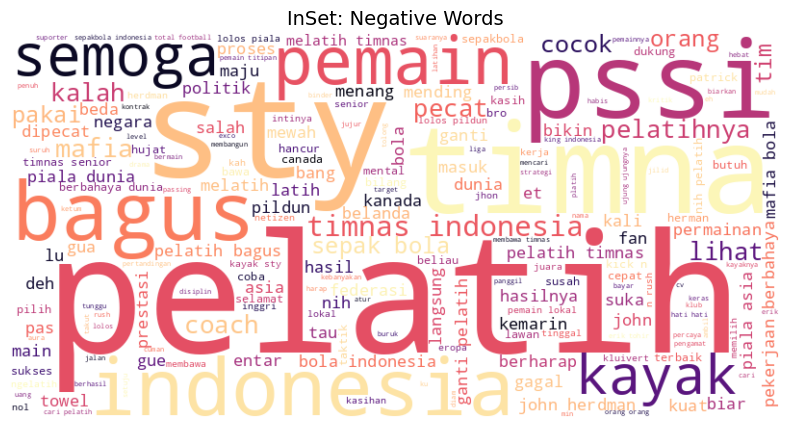

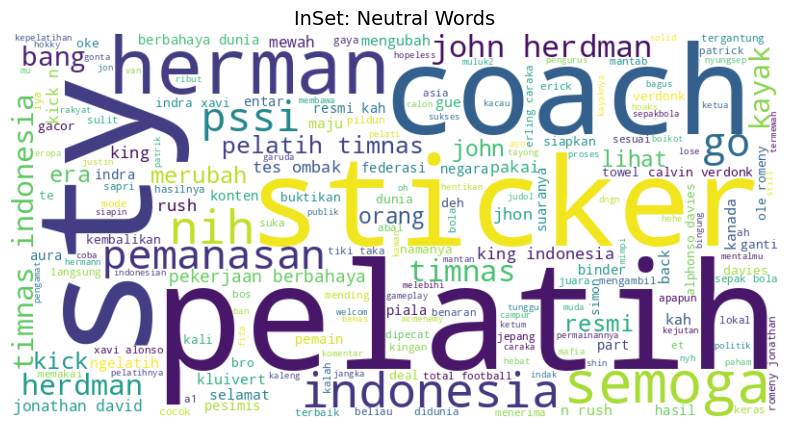

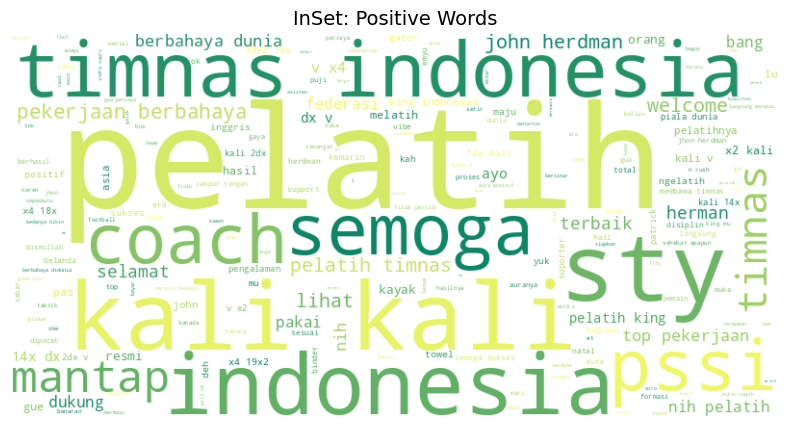

In [24]:
visualize_inset(df)

In [25]:
def freq_inset(df):
    print("TOP 10 KATA: LEXICON INSET")

    # Negative (Magma - Gelap)
    neg = df[df['sentiment_inset'] == 'Negative']['text_no_stopwords']
    plot_top_words(neg, "Top Kata Negative (InSet)", "magma")

    # Neutral (Viridis - Kalem)
    neu = df[df['sentiment_inset'] == 'Neutral']['text_no_stopwords']
    plot_top_words(neu, "Top Kata Neutral (InSet)", "viridis")

    # Positive (Summer - Cerah)
    pos = df[df['sentiment_inset'] == 'Positive']['text_no_stopwords']
    plot_top_words(pos, "Top Kata Positive (InSet)", "summer")

TOP 10 KATA: LEXICON INSET


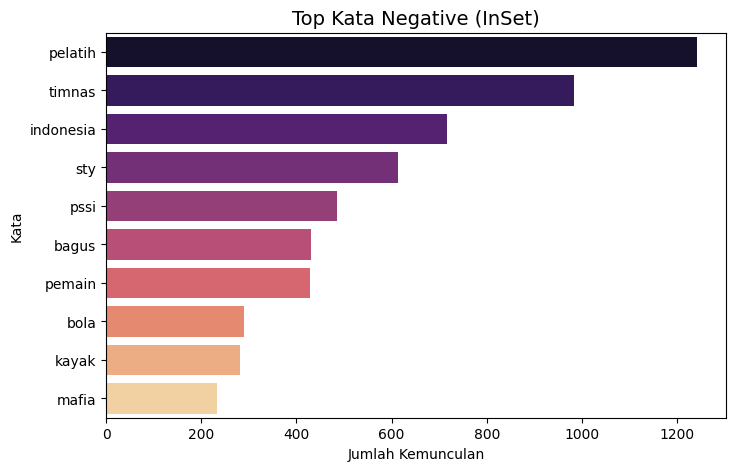

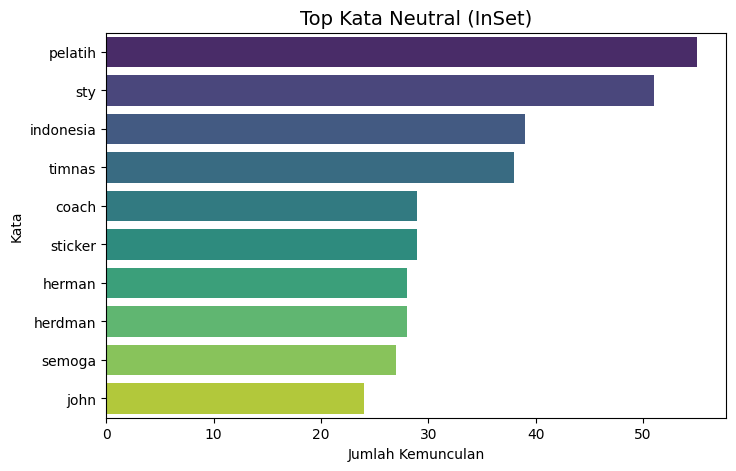

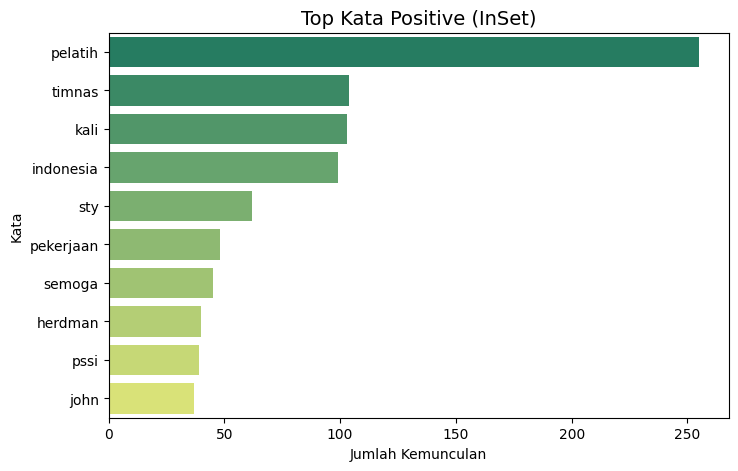

In [26]:
freq_inset(df)

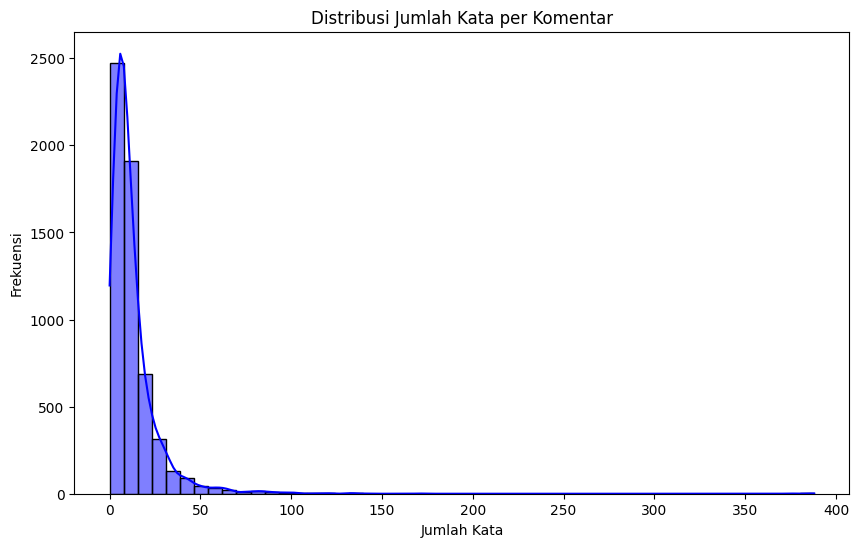

count    5765.000000
mean       12.523330
std        15.786088
min         0.000000
25%         5.000000
50%         9.000000
75%        15.000000
max       388.000000
Name: word_count, dtype: float64


In [27]:
df['word_count'] = df['text_norm'].str.split().str.len()

# Visualisasi Distribusi Panjang Kata
plt.figure(figsize=(10, 6))
sns.histplot(df['word_count'], bins=50, kde=True, color='blue')
plt.title('Distribusi Jumlah Kata per Komentar')
plt.xlabel('Jumlah Kata')
plt.ylabel('Frekuensi')
plt.show()

# Lihat statistik deskriptif
print(df['word_count'].describe())

# **MODELLING**

### **MAPPING**

In [44]:
# Mapping Label Sentimen (Text -> Angka)
label_map = {'Negative': 0, 'Neutral': 1, 'Positive': 2}
df['label_gemini'] = df['sentiment'].map(label_map)
df['label_inset'] = df['sentiment_inset'].map(label_map)

# Cek kalau ada label ngaco (selain Pos/Neg/Neu)
df = df.dropna(subset=['label_gemini'])
df['label_gemini'] = df['label_gemini'].astype(int)

df = df.dropna(subset=['label_inset'])
df['label_inset'] = df['label_inset'].astype(int)

### **SPLIT DATA**

In [45]:
train_dfgem, temp_dfgem = train_test_split(df, test_size = 0.2, random_state = 42, stratify = df['label_gemini'])
val_dfgem, test_dfgem = train_test_split(temp_dfgem, test_size = 0.5, random_state = 42, stratify = temp_dfgem['label_gemini'])

train_dfset, temp_dfset = train_test_split(df, test_size = 0.2, random_state = 42, stratify = df['label_inset'])
val_dfset, test_dfset = train_test_split(temp_dfset, test_size = 0.5, random_state = 42, stratify = temp_dfset['label_inset'])

datasetgem = DatasetDict({
    "train": Dataset.from_pandas(train_dfgem),
    "validation": Dataset.from_pandas(val_dfgem),
    "test": Dataset.from_pandas(test_dfgem)
})

datasetset = DatasetDict({
    "train": Dataset.from_pandas(train_dfset),
    "validation": Dataset.from_pandas(val_dfset),
    "test": Dataset.from_pandas(test_dfset)
})


## **Tokenization**

In [46]:
model_checkpoint = "indobenchmark/indobert-base-p1"

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def tokenize_function(examples):
  return tokenizer(examples['text_norm'], padding='max_length', truncation = True, max_length = 80)

tokenized_datasets_gem = datasetgem.map(tokenize_function, batched=True)
tokenized_datasets_gem = tokenized_datasets_gem.rename_column("label_gemini", "labels")

tokenized_datasets_set = datasetset.map(tokenize_function, batched=True)
tokenized_datasets_set = tokenized_datasets_set.rename_column("label_inset", "labels")

Map:   0%|          | 0/4612 [00:00<?, ? examples/s]

Map:   0%|          | 0/576 [00:00<?, ? examples/s]

Map:   0%|          | 0/577 [00:00<?, ? examples/s]

Map:   0%|          | 0/4612 [00:00<?, ? examples/s]

Map:   0%|          | 0/576 [00:00<?, ? examples/s]

Map:   0%|          | 0/577 [00:00<?, ? examples/s]

## **METRIK EVALUASI**

In [55]:
# Load Metric F1-Score (Standar Kompetisi)
f1_metric = evaluate.load("f1")
acc_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
  logits, labels = eval_pred
  predictions = np.argmax(logits, axis = -1)

  f1 = f1_metric.compute(predictions=predictions, references=labels, average='weighted')
  acc = acc_metric.compute(predictions=predictions, references=labels)

  return {"accuracy": acc["accuracy"], "f1_macro": f1['f1']}

id2label = {0: "Negative", 1: "Neutral", 2: "Positive"}
label2id = {"Negative": 0, "Neutral": 1, "Positive": 2}

model_gemini = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels = 3,
    id2label = id2label,
    label2id = label2id,
    hidden_dropout_prob = 0.3,
    attention_probs_dropout_prob=0.3
)

model_inset = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels = 3,
    id2label = id2label,
    label2id = label2id,
    hidden_dropout_prob = 0.3,
    attention_probs_dropout_prob=0.3
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## **Training (Fine-Tuning)**

In [56]:
training_args = TrainingArguments(
    output_dir="./indobert-base-optimized",

    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=1,

    learning_rate=3e-5,

    num_train_epochs=4,
    weight_decay=0.01,
    save_total_limit=1,

    # EVALUASI
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    fp16=True # Biar ngebut
)

### **LABELING GEMINI**

In [57]:


trainer = Trainer(
    model=model_gemini,
    args=training_args,
    train_dataset=tokenized_datasets_gem["train"],
    eval_dataset=tokenized_datasets_gem["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# GASKEUN!
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,0.761257,0.657986,0.659503
2,No log,0.774409,0.656250,0.657702
3,No log,0.762696,0.680556,0.680846
4,0.661000,0.764031,0.684028,0.684661


TrainOutput(global_step=580, training_loss=0.6329098537050445, metrics={'train_runtime': 175.2336, 'train_samples_per_second': 105.277, 'train_steps_per_second': 3.31, 'total_flos': 758424426600960.0, 'train_loss': 0.6329098537050445, 'epoch': 4.0})

### **LABELING INSET**

In [58]:


trainer = Trainer(
    model=model_inset,
    args=training_args,
    train_dataset=tokenized_datasets_set["train"],
    eval_dataset=tokenized_datasets_set["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# GASKEUN!
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,0.389666,0.859375,0.851804
2,No log,0.379357,0.876736,0.867734
3,No log,0.380168,0.888889,0.881918
4,0.345400,0.388198,0.887153,0.882598


TrainOutput(global_step=580, training_loss=0.32486683746864053, metrics={'train_runtime': 195.7941, 'train_samples_per_second': 94.221, 'train_steps_per_second': 2.962, 'total_flos': 758424426600960.0, 'train_loss': 0.32486683746864053, 'epoch': 4.0})

# **VALIDASI**

In [59]:
data_validasi  = ["Strategi jenius coach, bikin pemain bingung semua di lapangan 🤡",
                  "Pelatih tolol, taktik sampah kayak gini kok dibawa ke timnas. Pecat!",
                  "Bagus banget mainnya sampe kalah 4-0, lanjutken lawaknya coach!",
                  "Semoga timnas makin solid dan berkembang di bawah asuhan pelatih baru.",
                  "STY emang gak ada obat, pelatih yang sekarang mah ampas banget.",
                  "Pertandingan persahabatan akan dilaksanakan pada hari Sabtu malam.",
                  "Gacor banget skemanya, pemain jadi punya determinasi tinggi. Mantap!",
                  "Halah pelatih kelas dunia katanya, tapi taktiknya kelas tarkam. Bangsat.",
                  "John Herdman resmi menandatangani kontrak berdurasi dua tahun.",
                  "Mending balik ke Inggris aja lo, ngerusak mental pemain aja kerjanya."]

df_cek = pd.DataFrame({'text': data_validasi})

df_cek['text_cf'] = df_cek['text'].str.lower()

df_cek['text_eh'] = df_cek['text_cf'].fillna('').astype(str)
df_cek['text_eh'] = df_cek['text_eh'].apply(convert_emojis)

df_cek['text_clean'] = df_cek['text_eh'].str.replace(r"@\w+|#\w+|https?:\/\/\S+|www\.\S+|[^A-Za-z0-9\s]", " ", regex=True)
df_cek['text_clean'] = df_cek['text_clean'].str.replace(r"\s+", " ", regex=True).str.strip()

df_cek['text_norm'] = df_cek['text_clean'].apply(normalize_slang)

In [60]:
def predict_sentiment(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=80)
    # Move input tensors to the same device as the model
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        pred = torch.argmax(probs, dim=-1).item()

    label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
    return label_map[pred], probs[0][pred].item()

In [61]:


# Tambahkan kolom prediksi dan confidence ke dataframe
df_cek['pred_gemini'], df_cek['conf_gemini'] = zip(*df_cek['text_norm'].apply(
    lambda x: predict_sentiment(x, model_gemini, tokenizer)
))

print("--- HASIL VALIDASI MODEL GEMINI ---")
print(df_cek[['text_norm', 'pred_gemini', 'conf_gemini']])

--- HASIL VALIDASI MODEL GEMINI ---
                                                               text_norm  \
0           strategi jenius coach bikin pemain bingung semua di lapangan   
1    pelatih tolol taktik sampah kayak begini kok dibawa ke timnas pecat   
2         bagus banget mainnya sampai kalah 4 0 lanjutken lawaknya coach   
3  semoga timnas makin solid dan berkembang di bawah asuhan pelatih baru   
4      sty memang enggak ada obat pelatih yang sekarang mah ampas banget   
5      pertandingan persahabatan akan dilaksanakan pada hari sabtu malam   
6      gacor banget skemanya pemain jadi punya determinasi tinggi mantap   
7  halah pelatih kelas dunia katanya tapi taktiknya kelas tarkam bangsat   
8          john herdman resmi menandatangani kontrak berdurasi dua tahun   
9  mending balik ke inggris saja lo ngerusak mental pemain saja kerjanya   

  pred_gemini  conf_gemini  
0    Positive     0.672995  
1    Negative     0.980955  
2    Positive     0.807918  
3    Positi

In [62]:
# Tambahkan kolom prediksi dan confidence ke dataframe
df_cek['pred_inset'], df_cek['conf_inset'] = zip(*df_cek['text_norm'].apply(
    lambda x: predict_sentiment(x, model_inset, tokenizer)
))

print("--- HASIL VALIDASI MODEL INSET ---")
print(df_cek[['text_norm', 'pred_inset', 'conf_inset']])

--- HASIL VALIDASI MODEL INSET ---
                                                               text_norm  \
0           strategi jenius coach bikin pemain bingung semua di lapangan   
1    pelatih tolol taktik sampah kayak begini kok dibawa ke timnas pecat   
2         bagus banget mainnya sampai kalah 4 0 lanjutken lawaknya coach   
3  semoga timnas makin solid dan berkembang di bawah asuhan pelatih baru   
4      sty memang enggak ada obat pelatih yang sekarang mah ampas banget   
5      pertandingan persahabatan akan dilaksanakan pada hari sabtu malam   
6      gacor banget skemanya pemain jadi punya determinasi tinggi mantap   
7  halah pelatih kelas dunia katanya tapi taktiknya kelas tarkam bangsat   
8          john herdman resmi menandatangani kontrak berdurasi dua tahun   
9  mending balik ke inggris saja lo ngerusak mental pemain saja kerjanya   

  pred_inset  conf_inset  
0   Negative    0.989349  
1   Negative    0.997301  
2   Negative    0.997953  
3   Positive    0.85